In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [2]:
device = torch.device('cpu')

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### Exploring

In [3]:
df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
print(df['Usage'].unique())

print(len(df[df['Usage'] == 'Training']))
print(len(df[df['Usage'] == 'PublicTest']))
print(len(df[df['Usage'] == 'PrivateTest']))

['Training' 'PublicTest' 'PrivateTest']
28709
3589
3589


In [ ]:
df['pixels'] = [[int(y) for y in x.split()] for x in df['pixels']]
df.head()

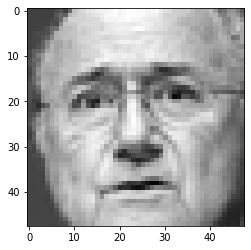

In [6]:
image = np.array(df.iloc[5][1]).reshape(48,48)

plt.imshow(image, cmap='gray')

### Define dataset

In [4]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

            X = torch.cat((X,X,X),0)

        return X, y

In [5]:
batch_size=32

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
# df_test = df[df['Usage'] == 'PrivateTest']

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(48),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

training_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
# test_set = FERDataset(df_test, train_transforms)


training_generator = torch.utils.data.DataLoader(training_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
validation_generator = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
# train_loader = torch.utils.data.DataLoader(test_set,
#                                              batch_size=batch_size, shuffle=False,
#                                              num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
images, labels = iter(training_generator).next()

images.size(), labels.size()

(torch.Size([32, 3, 48, 48]), torch.Size([32]))

In [19]:
labels

tensor([[6.],
        [5.],
        [6.],
        [0.],
        [6.],
        [3.],
        [6.],
        [4.],
        [6.],
        [6.],
        [4.],
        [1.],
        [3.],
        [4.],
        [4.],
        [6.],
        [6.],
        [4.],
        [3.],
        [6.],
        [5.],
        [3.],
        [4.],
        [6.],
        [0.],
        [5.],
        [3.],
        [6.],
        [0.],
        [6.],
        [3.],
        [4.],
        [0.],
        [5.],
        [3.],
        [4.],
        [6.],
        [2.],
        [4.],
        [4.],
        [4.],
        [3.],
        [3.],
        [2.],
        [4.],
        [0.],
        [4.],
        [4.],
        [3.],
        [3.],
        [3.],
        [0.],
        [3.],
        [4.],
        [4.],
        [4.],
        [6.],
        [6.],
        [3.],
        [2.],
        [2.],
        [6.],
        [3.],
        [6.]])

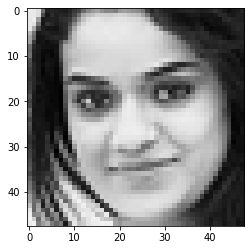

In [33]:
plt.imshow(images[5,:,:,:].permute(1,2,0))
plt.show()

In [29]:
labels

tensor([0, 1, 4, 6, 3, 3, 2, 0, 2, 0, 3, 0, 4, 2, 6, 2, 5, 0, 5, 3, 2, 5, 0, 4,
        0, 2, 4, 4, 0, 2, 3, 6, 3, 6, 0, 4, 6, 2, 6, 3, 0, 4, 4, 2, 6, 3, 5, 3,
        5, 6, 0, 3, 5, 4, 4, 3, 4, 2, 5, 3, 6, 3, 4, 3])

### Training

In [9]:
def plot(train_losses,train_acc,test_losses,test_acc, label):
    fig, axs = plt.subplots(1,2,figsize=(20,8))
    axs[0].plot(test_losses, label=label)
    axs[0].set_title("Test Loss")
    axs[1].plot(test_acc, label=label)
    axs[1].set_title("Test Accuracy")

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [10]:
def train(model, train_loader, optimizer,scheduler):
    model.train()
    pbar = tqdm(train_loader)
    running_loss = 0.0
    correct = 0
    processed = 0
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        running_loss = running_loss + loss.item()
        train_loss.append(loss)
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct = correct + pred.eq(target.view_as(pred)).sum().item()
        processed = processed + len(data)

        #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} running_loss={running_loss} threshold={best_loss*(0.996)}')
        train_acc.append(100*correct/processed)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} le={get_lr(optimizer)} Accuracy={100*correct/processed:0.2f}')

In [11]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    valid_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
class VGG16_baseline(nn.Module):
    def __init__(self, pretrained=False):
        super(VGG16_baseline, self).__init__()
        baseline = models.vgg16_bn(pretrained=pretrained)
        self.features = baseline.features
        self.avgpool = baseline.avgpool
        self.classifier = nn.Sequential(nn.Linear(25088, 4096, bias=True),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(4096, 4096, bias=True),
                                       nn.ReLU(),
                                       nn.Dropout(p=0.5),
                                       nn.Linear(4096, 7, bias=True))
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 25088)
        x = self.classifier(x)
        
        return x

In [ ]:
model=VGG16_baseline(pretrained=False)
model.to(device)
epochs=32
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer,scheduler)
    test(model, validation_generator)
    #scheduler.step()
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

  0%|          | 0/898 [00:00<?, ?it/s]

EPOCH: 0 LR: 0.0019999999999999983 


Loss=1.8718287944793701 Batch_id=206 le=0.002057574197138933 Accuracy=22.45:  23%|██▎       | 207/898 [03:57<2:23:21, 12.45s/it]

In [1]:
229376 * 7

1605632

In [13]:
models.vgg16_bn().avgpool(models.vgg16_bn().features(torch.rand(12, 3, 48, 48))).size()

torch.Size([12, 512, 7, 7])

In [14]:
512 * 7 * 7

25088